<a href="https://colab.research.google.com/github/vphcap-res/DOA_deep_learning/blob/main/LowDOA_DL_20250211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import os
import random
import numpy as np
import tensorflow as tf

# Set random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure full determinism in TensorFlow operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)

print("✅ Random seed set. Training will be reproducible.")

✅ Random seed set. Training will be reproducible.


# **Data  Loading and Preprocessing**

In [2]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Read the file (update path accordingly)
file_path = "/content/drive/My Drive/DOA-MeatDucks-SHAP/DOA-data_65-66_final_filtered.xlsx"
df = pd.read_excel(file_path)

# Display first few rows
df.head()

# n = 8220

Mounted at /content/drive


,date,order,farm,distance,head,age,bw,timeoutfarm,timearrive,slaughtertime,lairagetemp,doa,pctdoa,orderc,season,timetransport,durationtransport,lairagetime
0,2022-01-04,1,Pravatfarm,130.0,1200,43,3.18,1900-01-01 01:00:00,1900-01-01 03:00:00,1900-01-01 05:30:00,24.0,0,0.000000,Early,Winter,Night,120,150
1,2022-01-04,2,Pravatfarm,130.0,1200,43,3.12,1900-01-01 01:50:00,1900-01-01 04:10:00,1900-01-01 06:05:00,24.0,0,0.000000,Early,Winter,Night,140,115
2,2022-01-04,4,Pravatfarm,130.0,1100,43,3.20,1900-01-01 03:30:00,1900-01-01 06:14:00,1900-01-01 07:14:00,25.4,1,0.090909,Early,Winter,Night,164,60
3,2022-01-04,5,Pravatfarm,130.0,1028,43,3.04,1900-01-01 04:20:00,1900-01-01 06:27:00,1900-01-01 07:47:00,25.6,1,0.097276,Early,Winter,Morning,127,80
4,2022-01-04,6,Natfarm2,55.0,1300,43,3.37,1900-01-01 05:45:00,1900-01-01 07:19:00,1900-01-01 08:27:00,24.2,0,0.000000,Middle,Winter,Morning,94,68


In [3]:
# Remove 'distance' and create lowDOA/highDOA classes based on the 75th percentile
cutoff = df['pctdoa'].quantile(0.75)  # Calculate the 75th percentile cutoff

# Drop the 'distance' column
df2 = df.drop(columns=['distance']).copy()  # Copy ensures modifications do not affect df

# Assign DOA classes
df2['doaclass'] = df2['pctdoa'].apply(lambda x: 'lowDOA' if x < cutoff else 'highDOA')  # Fix: Use "<" instead of "<="

# Display the cutoff value and class distribution
print(f"✅ 75th Percentile Cutoff for pctdoa: {cutoff:.6f}")
print("\nClass Distribution:")
print(df2['doaclass'].value_counts(normalize=True) * 100)  # Corrected to df2

# Show first few rows
df2.head()

✅ 75th Percentile Cutoff for pctdoa: 0.153846

Class Distribution:
doaclass
lowDOA     73.783455
highDOA    26.216545
Name: proportion, dtype: float64


,date,order,farm,head,age,bw,timeoutfarm,timearrive,slaughtertime,lairagetemp,doa,pctdoa,orderc,season,timetransport,durationtransport,lairagetime,doaclass
0,2022-01-04,1,Pravatfarm,1200,43,3.18,1900-01-01 01:00:00,1900-01-01 03:00:00,1900-01-01 05:30:00,24.0,0,0.000000,Early,Winter,Night,120,150,lowDOA
1,2022-01-04,2,Pravatfarm,1200,43,3.12,1900-01-01 01:50:00,1900-01-01 04:10:00,1900-01-01 06:05:00,24.0,0,0.000000,Early,Winter,Night,140,115,lowDOA
2,2022-01-04,4,Pravatfarm,1100,43,3.20,1900-01-01 03:30:00,1900-01-01 06:14:00,1900-01-01 07:14:00,25.4,1,0.090909,Early,Winter,Night,164,60,lowDOA
3,2022-01-04,5,Pravatfarm,1028,43,3.04,1900-01-01 04:20:00,1900-01-01 06:27:00,1900-01-01 07:47:00,25.6,1,0.097276,Early,Winter,Morning,127,80,lowDOA
4,2022-01-04,6,Natfarm2,1300,43,3.37,1900-01-01 05:45:00,1900-01-01 07:19:00,1900-01-01 08:27:00,24.2,0,0.000000,Middle,Winter,Morning,94,68,lowDOA


In [4]:
y = (df2['doaclass'] == 'lowDOA').astype(int)  # lowDOA = 1, highDOA = 0
print("✅ Unique Values in y:", np.unique(y))

✅ Unique Values in y: [0 1]


In [5]:
print("✅ Mapping of Target Classes:")
print(df2[['doaclass']].drop_duplicates().assign(encoded=y.unique()))

✅ Mapping of Target Classes:
  doaclass  encoded
0   lowDOA        1
5  highDOA        0


In [6]:
print("\n🔍 Checking Label Assignment:")
print(f"lowDOA is mapped to: {y[df2['doaclass'] == 'lowDOA'].unique()}")
print(f"highDOA is mapped to: {y[df2['doaclass'] == 'highDOA'].unique()}")


🔍 Checking Label Assignment:
lowDOA is mapped to: [1]
highDOA is mapped to: [0]


In [7]:
# Create df3 as a copy of df2 to avoid modifying the original dataset
df3 = df2.copy()

# List of columns to remove
columns_to_remove = [
    'date', 'order', 'farm', 'timeoutfarm', 'timearrive', 'slaughtertime',
    'doa', 'pctdoa'
]

# Drop the specified columns
df3.drop(columns=columns_to_remove, inplace=True, errors='ignore')

# Display the first few rows to confirm changes
print("✅ Columns removed successfully. Preview of df3:\n")
print(df3.head())

✅ Columns removed successfully. Preview of df3:

   head  age    bw  lairagetemp  orderc  season timetransport  \
0  1200   43  3.18         24.0   Early  Winter         Night   
1  1200   43  3.12         24.0   Early  Winter         Night   
2  1100   43  3.20         25.4   Early  Winter         Night   
3  1028   43  3.04         25.6   Early  Winter       Morning   
4  1300   43  3.37         24.2  Middle  Winter       Morning   

   durationtransport  lairagetime doaclass  
0                120          150   lowDOA  
1                140          115   lowDOA  
2                164           60   lowDOA  
3                127           80   lowDOA  
4                 94           68   lowDOA  


# **Data Splitting**

In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Separate features (X) and target (y)
X = df3.drop(columns=['doaclass'])  # Features
y = df3['doaclass']  # Target variable

from sklearn.model_selection import train_test_split

# Convert categorical variables to numeric using one-hot encoding
X = pd.get_dummies(df3.drop(columns=['doaclass']), drop_first=True)
y = (df3['doaclass'] == 'lowDOA').astype(int)  # Convert target to binary

# Convert categorical variables to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Ensure a balanced split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ New Train-Test Split Completed.")
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))  # Should now show [0, 1]

✅ New Train-Test Split Completed.
Unique values in y_train: [0 1]
Unique values in y_test: [0 1]


**Check Class Imbalance**

✅ Class Distribution in Dataset:
doaclass
lowDOA     6065
highDOA    2155
Name: count, dtype: int64

Proportion (%):
doaclass
lowDOA     73.783455
highDOA    26.216545
Name: count, dtype: float64


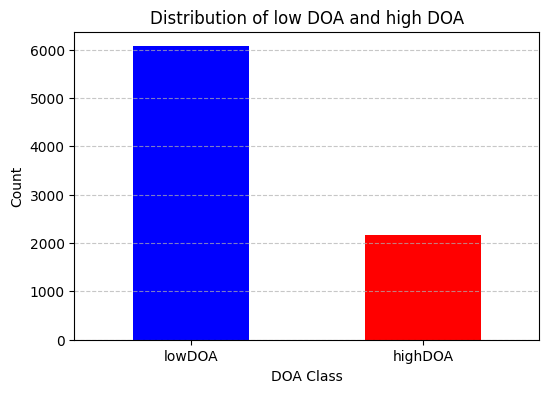

In [9]:
import matplotlib.pyplot as plt

# Count occurrences of each class
class_counts = df3['doaclass'].value_counts()

# Print proportion
print("✅ Class Distribution in Dataset:")
print(class_counts)
print("\nProportion (%):")
print(class_counts / class_counts.sum() * 100)

# Plot bar chart for visualization
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['blue', 'red'])
plt.xlabel("DOA Class")
plt.ylabel("Count")
plt.title("Distribution of low DOA and high DOA")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## **Resampling**

In [11]:
# Install imbalanced-learn if not installed
!pip install imbalanced-learn  # Run this once in Colab/Jupyter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN  # ✅ Corrected Import
import numpy as np

# Apply Both Upsampling (lowDOA) & Undersampling (highDOA)
smote_enn = SMOTEENN(random_state=42)  # Adjust parameters if needed
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print("✅ Resampling Completed (Upsampling lowDOA + Undersampling highDOA).")
print("Class Distribution in Resampled y_train:", np.unique(y_train_resampled, return_counts=True))

✅ Resampling Completed (Upsampling lowDOA + Undersampling highDOA).
Class Distribution in Resampled y_train: (array([0, 1]), array([3016, 2167]))


**Feature Scaling**

In [13]:
# Apply Feature Scaling (After Resampling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Test set is NOT resampled, just scaled

print("✅ Feature Scaling Applied.")

✅ Feature Scaling Applied.


# **Build and Train the Deep Learning Model**

## **1️⃣ Base MLP Model (Simple Architecture)**

In [14]:
# Convert all boolean columns to int (0 or 1)
X_train = X_train.astype(int)
X_test = X_test.astype(int)

print("✅ Boolean columns successfully converted to integers.")
print(X_train.dtypes)  # Verify all columns are now int64 or float64

✅ Boolean columns successfully converted to integers.
head                     int64
age                      int64
bw                       int64
lairagetemp              int64
durationtransport        int64
lairagetime              int64
orderc_Late              int64
orderc_Middle            int64
season_Summer            int64
season_Winter            int64
timetransport_Morning    int64
timetransport_Night      int64
dtype: object


**Feature Scaling**

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling applied successfully.")

✅ Feature scaling applied successfully.


**Model Training**

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(float))  # Ensure float conversion
X_test_scaled = scaler.transform(X_test.astype(float))

print("✅ Feature Scaling Completed. All Data is Numeric.")

✅ Feature Scaling Completed. All Data is Numeric.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Define the model
model_base = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Correct input layer
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_base.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_base = model_base.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

print("✅ Model Successfully Trained.")

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7106 - loss: 0.5778 - val_accuracy: 0.7488 - val_loss: 0.5283
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7551 - loss: 0.5205 - val_accuracy: 0.7494 - val_loss: 0.5263
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7597 - loss: 0.5159 - val_accuracy: 0.7536 - val_loss: 0.5255
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7620 - loss: 0.5132 - val_accuracy: 0.7591 - val_loss: 0.5247
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7620 - loss: 0.5113 - val_accuracy: 0.7573 - val_loss: 0.5243
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7638 - loss: 0.5098 - val_accuracy: 0.7616 - val_loss: 0.5238
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7659 - loss: 0.5085 - val_accuracy: 0.7628 - val_loss: 0.5234
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7672 - loss: 0.5074 - val_accuracy

## **2️⃣ Deeper MLP with Dropout**

In [18]:
model_deep = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_deep = model_deep.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7260 - loss: 0.5689 - val_accuracy: 0.7433 - val_loss: 0.5329
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7474 - loss: 0.5335 - val_accuracy: 0.7512 - val_loss: 0.5278
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7519 - loss: 0.5302 - val_accuracy: 0.7573 - val_loss: 0.5268
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7543 - loss: 0.5239 - val_accuracy: 0.7585 - val_loss: 0.5250
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7561 - loss: 0.5222 - val_accuracy: 0.7567 - val_loss: 0.5257
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7619 - loss: 0.5182 - val_accuracy: 0.7567 - val_loss: 0.5229
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7614 - loss: 0.5181 - val_accuracy: 0.7555 - val_loss: 0.5229
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7645 - loss: 0.5172 - val_accuracy: 0.7579 

## **3️⃣ Wide MLP (More Neurons per Layer)**

In [19]:
model_wide = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_wide.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_wide = model_wide.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7151 - loss: 0.5663 - val_accuracy: 0.7579 - val_loss: 0.5278
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7593 - loss: 0.5243 - val_accuracy: 0.7567 - val_loss: 0.5265
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7560 - loss: 0.5223 - val_accuracy: 0.7622 - val_loss: 0.5240
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7542 - loss: 0.5208 - val_accuracy: 0.7622 - val_loss: 0.5226
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7625 - loss: 0.5159 - val_accuracy: 0.7628 - val_loss: 0.5228
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7613 - loss: 0.5155 - val_accuracy: 0.7628 - val_loss: 0.5208
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7640 - loss: 0.5159 - val_accuracy: 0.7622 - val_loss: 0.5212
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7613 - loss: 0.5139 - val_accuracy: 0.7622

## **4️⃣ L1 & L2 Regularization (Prevents Overfitting)**

In [20]:
from tensorflow.keras.regularizers import l1_l2

model_regularized = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001), input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_regularized.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_regularized = model_regularized.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7122 - loss: 1.3942 - val_accuracy: 0.7464 - val_loss: 0.9351
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7503 - loss: 0.8659 - val_accuracy: 0.7476 - val_loss: 0.7093
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7463 - loss: 0.6783 - val_accuracy: 0.7451 - val_loss: 0.6207
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7443 - loss: 0.6077 - val_accuracy: 0.7457 - val_loss: 0.5869
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7408 - loss: 0.5801 - val_accuracy: 0.7482 - val_loss: 0.5711
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7449 - loss: 0.5682 - val_accuracy: 0.7488 - val_loss: 0.5623
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7449 - loss: 0.5595 - val_accuracy: 0.7524 - val_loss: 0.5577
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7456 - loss: 0.5580 - val_accuracy: 0.7488

## **5️⃣ Optimized Learning Rate with Adam**

In [21]:
model_tuned_lr = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_tuned_lr.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

history_tuned_lr = model_tuned_lr.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7207 - loss: 0.5858 - val_accuracy: 0.7470 - val_loss: 0.5373
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7456 - loss: 0.5440 - val_accuracy: 0.7482 - val_loss: 0.5326
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7455 - loss: 0.5381 - val_accuracy: 0.7518 - val_loss: 0.5311
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7500 - loss: 0.5310 - val_accuracy: 0.7512 - val_loss: 0.5284
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7503 - loss: 0.5247 - val_accuracy: 0.7500 - val_loss: 0.5268
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7492 - loss: 0.5254 - val_accuracy: 0.7530 - val_loss: 0.5251
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7558 - loss: 0.5208 - val_accuracy: 0.7567 - val_loss: 0.5249
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7598 - loss: 0.5200 - val_accuracy: 0.756

# **Comparing the Models**

In [22]:
import numpy as np
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_test: [0 1]


In [23]:
from sklearn.metrics import classification_report

def evaluate_model(model, name):
    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    print(f"\n✅ {name} Model Performance:")
    print(classification_report(y_test, y_pred, target_names=['lowDOA', 'highDOA']))

# Evaluate all models
evaluate_model(model_base, "Base MLP")
evaluate_model(model_deep, "Deep MLP")
evaluate_model(model_wide, "Wide MLP")
evaluate_model(model_regularized, "Regularized MLP")
evaluate_model(model_tuned_lr, "Optimized Learning Rate MLP")

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step

✅ Base MLP Model Performance:
              precision    recall  f1-score   support

      lowDOA       0.60      0.28      0.38       431
     highDOA       0.79      0.93      0.85      1213

    accuracy                           0.76      1644
   macro avg       0.70      0.61      0.62      1644
weighted avg       0.74      0.76      0.73      1644

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Deep MLP Model Performance:
              precision    recall  f1-score   support

      lowDOA       0.62      0.24      0.34       431
     highDOA       0.78      0.95      0.85      1213

    accuracy                           0.76      1644
   macro avg       0.70      0.59      0.60      1644
weighted avg       0.74      0.76      0.72      1644

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Wide MLP Model Performance:
              precision    recall  f1-score   support

      lowDOA       0.61      0.22      0.32       431
     highDOA       0.77   